# Pierre Vambenepe for www.canari.dev (Feb-2021)
# Deutsche Boerse A7 usage example for equity options


**Downloading intraday prices and trades from A7 and calibrating a vol surface**

Abstract :
Any data analysis project on options must start by computing an implicit volatility surface.
This notebook associated with following dependencies takes care of this initial stage :
you will need to download the following files from the code folder :
- PricingAndCalibration.py (does the calibration heacy lifting)
- DateAndTime.py (for date related functions)
- Setup.py (in order to indicate where input and output must go)

You will also need to load then minsize_level_tb.yml pre-processing code in A7 (see readme file for more explanations)


In [1]:
# Indicate here the folders where you want the quotes and trades data (folder1)
# and the calibration result with "fleshed" trades (folder 2)

folder1 = 'D:/Users/GitHub/TradesDynamics/processed'
folder2 = 'D:/Users/GitHub/TradesDynamics/parameters'

import os
os.makedirs(folder1, exist_ok=True)
os.makedirs(folder1 + '/raw', exist_ok=True)
os.makedirs(folder2, exist_ok=True)

In [2]:
# We are now importing public libraries
import numpy as np
import pandas as pd
import QuantLib as ql #free derivatives pricing package
import math
import datetime
import matplotlib.pyplot as plt
import requests
import warnings

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 30)

In [3]:
# ...and specific libraries available in this git

from DateAndTime import DateAndTime
# uses QuantLib to calculate numbers of business day between dates and generate a list expiration dates

from PricingAndCalibration import Pricing
# uses Quantlib to price European and American options with continuous dividend yield and the associated greeks

from PricingAndCalibration import FittingSpline
# uses scipy-UnivariateSpline to fit a 2nd degree spline through the implicit vol of bid and ask quotes (for each maturity)

# We will first retrieve trades and order book data from A7

In [4]:
#indicate your A7 credentials :
owner = 'your A7 username here'

API_TOKEN = "Bearer " + "your A7 API token here"
# The API token is obtained by clicking on your name in the upper right corner of the A7 Analytics Platform, and then on "API token generation"

proxies = {
    "http": "",  # Enter http Proxy if needed",
    "https": ""  # Enter https Proxy if needed",
}

In [5]:
#choose a date for analysis :
reference_date = '20210105'

# Select an underlying
udl = 'DAI'
isin = 'DE0007100000'

# Select an algo for the retrieving of quotes.
# 'top_level' algo is pre-loaded in A7
# 'minsize_level_tb' allows you to look into the orderbook until finding a minimum number of lots.
# 'minsize_level_tb' is given in this git as a .yml file and must be loaded first in your A7 account.
algo = 'minsize_level_tb'

# If you have chosen the 'minsize_level' algo :
min_lots = 30

In [6]:
#Some unimportant parameters and inital settings

# filter settings to speed up the process
# for 1 year maturity option with an adjustment in sqrt(T)
moneyness_range_call = (-0.4, 0.7)
moneyness_range_put = (-0.7, 0.4)

DT = DateAndTime('2021-01-05', '2021-01-05')

df_orderbook = pd.DataFrame()
df_trades = pd.DataFrame()

In [7]:
# Let's first find the identification code for the stock itself :

url = 'https://a7.deutsche-boerse.com/api/v1/rdi/XETR/{}?mode=detailed'.format(reference_date)
r = requests.get(url=url,  headers={'Authorization': API_TOKEN}, proxies = proxies)
res = r.json()

lst_ms = np.array([x['MarketSegment'] for x in res['MarketSegments']])
indx = np.where(lst_ms==isin)[0][0]
segmentIDudl = res['MarketSegments'][indx]['MarketSegmentID']
print('Market Segment for the underlying {} :: {}'.format(udl, str(segmentIDudl)))

url = 'https://a7.deutsche-boerse.com/api/v1/rdi/XETR/{}/{}?mode=detailed'.format(reference_date, segmentIDudl)
r = requests.get(url=url, headers={'Authorization': API_TOKEN}, proxies = proxies)
res_u = r.json()
security = res_u['Securities'][0]

Market Segment for the underlying DAI :: 52983


In [8]:
# Let's now get the get all options segments for this underlying (we will filter them mater)

url = 'https://a7.deutsche-boerse.com/api/v1/rdi/XEUR/{}?mode=detailed'.format(reference_date)
r = requests.get(url = url,  headers={'Authorization': API_TOKEN}, proxies = proxies)
res = r.json()

lst_ms = np.array([x['MarketSegment'] for x in res['MarketSegments']])
indx = np.where(lst_ms==udl)[0][0]
segmentIDopt = res['MarketSegments'][indx]['MarketSegmentID']
print('Market Segment for options on {} :: {}'.format(udl, str(segmentIDopt)))

url = 'https://a7.deutsche-boerse.com/api/v1/rdi/XEUR/{}/{}?mode=detailed'.format(reference_date, segmentIDopt)
r = requests.get(url = url,  headers={'Authorization': API_TOKEN}, proxies = proxies)
res_i = r.json()

Market Segment for options on DAI :: 352


In [9]:
# We will now retrieve the quotes (underlying and options)

selected_fields = ['SecurityDesc', 'SecurityID']
selected_fields_desc = ['PutOrCall', 'StrikePrice', 'ContractMultiplier', 'ExerciseStyle']

raw = pd.DataFrame()
matulist = sorted(list(set([str(elt['MaturityDate']) for elt in res_i['Securities'] if elt['MaturityDate'] != None])))

for matu in ['UDL'] + matulist:
    print(matu)

    df = pd.DataFrame(columns=['SegmentID'] + selected_fields + selected_fields_desc)

    if matu == 'UDL':
        df.loc[0] = [segmentIDudl, security['SecurityDesc'], security['SecurityID'], 'S', None, 1, None]
        df['in_range'] = True
    else:
        i = 0
        for x in res_i['Securities']:
            if (str(x['MaturityDate']) == matu) and (x['SecurityType'] == 'OPT'):
                df.loc[i] = [segmentIDopt] + [x[elt] for elt in selected_fields] + \
                            [x['DerivativesDescriptorGroup']['SimpleInstrumentDescriptorGroup'][elt] for elt in selected_fields_desc]
                i += 1

        df.sort_values(by=['StrikePrice', 'PutOrCall'], ascending = [True, True], inplace=True)

        # Computing moneyness/sqrt(T) will allow us to filter out deep ITM options
        TTM = DT.time_between(pd.Timestamp(reference_date), pd.Timestamp(matu))
        df['moneyness_T'] = df.apply(lambda opt: math.log(opt.StrikePrice / FVU) / (max(3.0 / 12.0, TTM) ** 0.5), axis='columns')
        # the forward ratio is unknown at this stage so we take a high dividend rate of 8% as instead, hence the 0.92
        df['moneyness_T_w_div'] = df.apply(lambda opt: math.log(opt.StrikePrice / FVU*0.92) / (max(3.0 / 12.0, TTM) ** 0.5), axis='columns')
        df['in_range'] = df.apply(lambda opt: (opt.moneyness_T_w_div > moneyness_range_call[0]) and (opt.moneyness_T < moneyness_range_call[1])  \
                if opt.PutOrCall == '1' else \
                (opt.moneyness_T_w_div > moneyness_range_put[0]) and (opt.moneyness_T < moneyness_range_put[1]), axis='columns')

        df = df.loc[df.in_range]

    for index, opt in df.iterrows():
        
        if opt['PutOrCall'] == 'S':
            market = 'XETR'
            url = 'https://a7.deutsche-boerse.com/api/v1/algo/{}/top_level/'.format(owner)
            url = url+"run?marketId={}&date={}&marketSegmentId={}&securityId={}".format(market, reference_date, opt['SegmentID'], opt['SecurityID'])

        else:
            market = 'XEUR'
            if algo == 'top_level':
                url = 'https://a7.deutsche-boerse.com/api/v1/algo/{}/top_level/'.format(owner)
                url = url+"run?marketId={}&date={}&marketSegmentId={}&securityId={}".format(market, reference_date, opt['SegmentID'], opt['SecurityID'])
            elif algo == 'minsize_level_tb':
                url = 'https://a7.deutsche-boerse.com/api/v1/algo/{}/minsize_level_tb/'.format(owner)
                url = url+"run?marketId={}&date={}&marketSegmentId={}&securityId={}&from_h=9&from_m=0&&min_lots={}&to_h=17&to_m=30&ts_step=5".format(market, reference_date, opt['SegmentID'], opt['SecurityID'], min_lots)

        r = requests.get(url=url,  headers={'Authorization': API_TOKEN}, proxies = proxies)
        res = r.json()

        if type(res) == list:
            if (algo == 'minsize_level_tb') and (opt['PutOrCall'] != 'S'):
                df_opt = pd.DataFrame.from_dict(res[0]['series'][0]['content'])
                df_opt.ts = df_opt.ts.astype(np.int64)
                df_opt.ts = pd.to_datetime(df_opt.ts)
                df_opt.set_index('ts', inplace=True)

                df_opt[selected_fields_desc] = opt[selected_fields_desc]

                df_opt['matu'] = matu
                df_orderbook = df_orderbook.append(df_opt)

            else:
                bid_ask_sampled = {}
                for i, bidask in enumerate(['bid', 'ask']):
                        df_price = pd.DataFrame(index=res[0]['series'][i]['content']['ts'])
                        df_price = df_price.assign(pv=res[0]['series'][i]['content']['price'])

                        df_price = df_price.dropna()
                        if df_price.shape[0] > 0:
                            df_price['pv'] = df_price['pv'].astype(float)/1e3
                            df_price.columns = [bidask]
                            df_price.index = df_price.index.astype(np.int64)
                            df_price.index = pd.to_datetime(df_price.index)

                            for elt in selected_fields_desc:
                                df_price[elt] = opt[elt]
                            df_price['matu'] = matu

                            if opt['PutOrCall'] == 'S':
                                df_raw = df_price.copy()
                                df_raw.rename(columns={bidask: 'level'}, inplace=True)
                                df_raw['bidask'] = bidask
                                for elt in selected_fields:
                                    df_raw[elt] = opt[elt]
                                raw = raw.append(df_raw)

                            index = pd.date_range(df_price.index[0].round('T'), df_price.index[-1], freq='1T')
                            df_price = df_price.reindex(index, method='ffill')

                            bid_ask_sampled[bidask] = df_price

                if len(bid_ask_sampled) == 2:
                    df_opt = pd.merge(bid_ask_sampled['bid'][['bid']], bid_ask_sampled['ask'], how='inner', left_index=True, right_index=True)
                    if opt['PutOrCall'] == 'S':
                        FVU = (df_opt.bid.median() + df_opt.ask.median())/2
                    df_orderbook = df_orderbook.append(df_opt)
                

raw.to_pickle(folder1 + '/raw/Quotes_' + '{}_{}.pkl'.format(udl, reference_date))
df_orderbook.to_pickle(folder1 + '/Quotes_' + udl + '.pkl')

UDL
20210115
20210219
20210319
20210618
20210917
20211217
20220617
20221216
20230616
20231215
20241220
20251219


In [10]:
# Finally, we retreive the trades

selected_fields = ['SecurityDesc', 'SecurityID']
selected_fields_desc = ['PutOrCall', 'StrikePrice', 'ContractMultiplier', 'ExerciseStyle']

for matu in matulist:

    df = pd.DataFrame(columns=['SegmentID'] + selected_fields + selected_fields_desc)
    i = 0
    
    for x in res_i['Securities']:
        if (str(x['MaturityDate']) == matu) and (x['SecurityType'] == 'OPT'):
            df.loc[i] = [segmentIDopt] + [x[elt] for elt in selected_fields] + \
                        [x['DerivativesDescriptorGroup']['SimpleInstrumentDescriptorGroup'][elt] for elt in selected_fields_desc]
            i += 1

    for index, opt in df.iterrows():

        url = 'https://a7.deutsche-boerse.com/api/v1/algo/{}/trades_PVA/'.format(owner)

        market = 'XEUR'
        url = url+"run?marketId={}&date={}&marketSegmentId={}&securityId={}".format(market, reference_date, opt['SegmentID'], opt['SecurityID'])
        r = requests.get(url=url,  headers={'Authorization': API_TOKEN}, proxies = proxies)
        res = r.json()

        if (type(res) == list) and (len(res[0]['series'][0]['content']['time'])>0):
            df_opt = pd.DataFrame.from_dict(res[0]['series'][0]['content'])
            df_opt.index = df_opt.index.astype(np.int64)
            df_opt.index = pd.to_datetime(df_opt.index)
            for field in ['time', 'priots', 'bidentry', 'askentry']:
                df_opt[field] = df_opt[field].astype(np.int64)
                df_opt[field] = pd.to_datetime(df_opt[field])
            df_opt.set_index('time', inplace=True)

            df_opt[selected_fields_desc] = opt[selected_fields_desc]

            df_opt['matu'] = matu
            df_opt['SegmentID'] = opt['SegmentID']
            df_opt['SecurityID'] = opt['SecurityID']
            df_trades = df_trades.append(df_opt)

df_trades.to_pickle(folder1 + '/Trades_' + udl + '.pkl')

# Let's now fit volatility spline curves on the bid and ask quotes separately

In [11]:
warnings.filterwarnings('ignore')

FS = FittingSpline(udl, DT, folder1, folder2)

FS.fit_all()

for reference_date in [elt for elt in DT.dates_list]:

    print(reference_date)
    matulist = [elt for elt in DT.get_matu_list(reference_date) if elt != reference_date]

    for matu in matulist:
        print('   ' + matu)

        #ini_day intializies the dataframe and sets the starting implicit vol flat at 30%
        FS.ini_day(reference_date, matu)

        #fit_day starts a process of fitting the vol curve every 5 minutes allong with the forward ratio (dividend + repo yield)
        FS.fit_day()

    FS.df_params.to_pickle(folder2 + '/Params_' + udl + '.pkl')

    
print(FS.df_params[['spline_bid', 'spline_ask']].head(5))

20210105
   20210115
   20210219
   20210319
   20210416
   20210514
   20210618
   20210917
   20211217
    leeway : 4
    leeway : 4
   20220617
   20221216
20210105
   20210115
   20210219
   20210319
   20210416
   20210514
   20210618
   20210917
   20211217
   20220617
   20221216
                                                                     spline_bid                                         spline_ask
ts                  matu                                                                                                          
2021-01-05 08:05:00 20210115  <scipy.interpolate.fitpack2.LSQUnivariateSplin...  <scipy.interpolate.fitpack2.LSQUnivariateSplin...
2021-01-05 08:10:00 20210115  <scipy.interpolate.fitpack2.LSQUnivariateSplin...  <scipy.interpolate.fitpack2.LSQUnivariateSplin...
2021-01-05 08:15:00 20210115  <scipy.interpolate.fitpack2.LSQUnivariateSplin...  <scipy.interpolate.fitpack2.LSQUnivariateSplin...
2021-01-05 08:20:00 20210115  <scipy.interpolate.fitpack2

Congratulations, you have created a parameters dataframe with the fitted spline curve for the bid and ask implicit vol


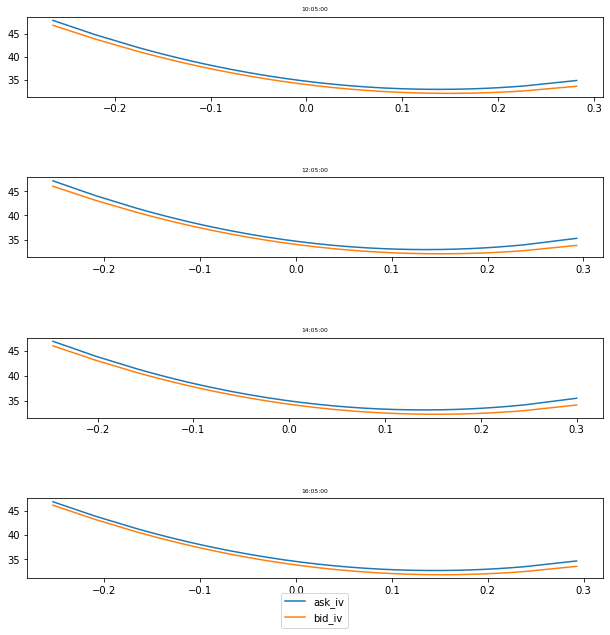

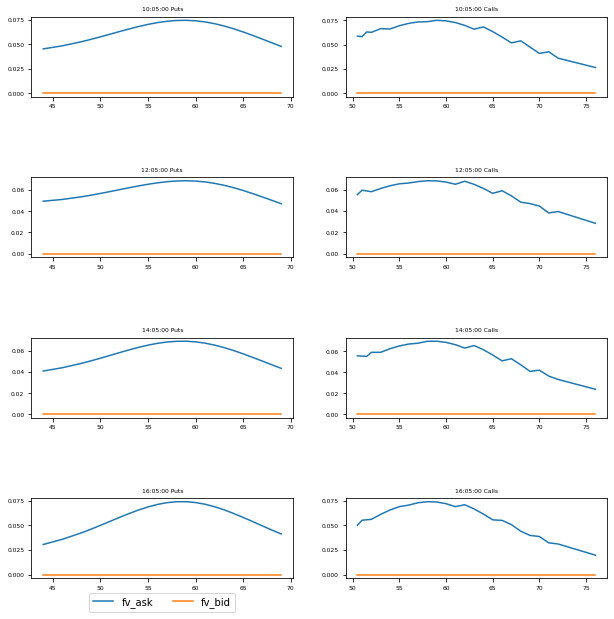

In [12]:
#Let's now graph what we have done :

FS.graph(day="20210105", matu="20210319")

# First graph : the spline curves themselves at different times of day

# Second graphs : We use these volatilities to compute a fair bid and fair ask price for each strike 
# (Put on the left, Calls on the right).
# Since we are representing on the same graph options with different strikes, the values are rebased 
# so that the model (or fair_value) bid is at 0, allowing for a more compact graph
